# Python Timing and Time Comparison

In [ ]:
import numpy as np
import pandas as pd
import ripser
import matplotlib.pyplot as plt
import time
from TDAvec import DiagToPD, computeVPB
import plotnine as p9
from plotnine import ggplot, aes, geom_point, geom_line, geom_errorbar, labs, geom_hline

## Python Generation

In [188]:
# generated `n` random points distributed along circle with radius `r` and standard deviation `sd`
def genCirle(n, r=1, sd=0.2):
    th = np.random.uniform(low = 0, high = 2*np.pi, size = n)
    x = r*np.cos(th) + np.random.normal(loc = 0, scale =sd, size = n)
    y = r*np.sin(th) + np.random.normal(loc = 0, scale = sd, size = n)
    xy = np.transpose( np.array([x,y]))
    return xy


In [189]:
# makes a simulation: for given number of points 
#   create point cloud, 
#   generate PD
#   vectorize using VPB with dim1, dim2
# returns data frame with calculation times
def make_sim(N):
    totTime_start = time.perf_counter()
    # create PD
    genTime_start = time.perf_counter()
    circ = genCirle(N)
    D = ripser.ripser(circ, thresh = 2.2)["dgms"]
    PD = DiagToPD(D)
    PD[0] = PD[0][:, :-1]
    # prepare VPB parameters
    ySeqH0 = np.quantile(PD[0][1], np.arange(0, 1.1, 0.2))
    xSeqH1 = np.quantile(PD[1][0], np.arange(0, 1.1, 0.2))
    ySeqH1 = np.quantile(PD[1][1], np.arange(0, 1.1, 0.2))
    genTime_ = time.perf_counter() - genTime_start
    vectTime_start = time.perf_counter()
    # make vectorization
    vpb0 = computeVPB(PD, homDim=0, xSeq=[], ySeq=ySeqH0)
    vpb1 = computeVPB(PD, homDim=1, xSeq=xSeqH1, ySeq=ySeqH1)
    vectTime_ = time.perf_counter() - vectTime_start
    totTime_ = time.perf_counter() - totTime_start
    # save the results
    df_ = pd.DataFrame({"N":[N], "totTime":totTime_, "genTime":genTime_, "vectTime":vectTime_})
    return df_


Collecting statistics

In [190]:
nSim = 100
times = pd.DataFrame()
for N in [50, 100, 200, 250, 300, 350, 400, 500]:
    print(N, end=" ")
    for i in range(nSim):
        print(".", end="")
        df_ = make_sim(N)
        times = pd.concat([times, df_])
    print()
    

50 ....................................................................................................
100 ....................................................................................................
200 ....................................................................................................
250 ....................................................................................................
300 ....................................................................................................
350 ....................................................................................................
400 ....................................................................................................
500 ....................................................................................................


Here is how different timing depend on number of points

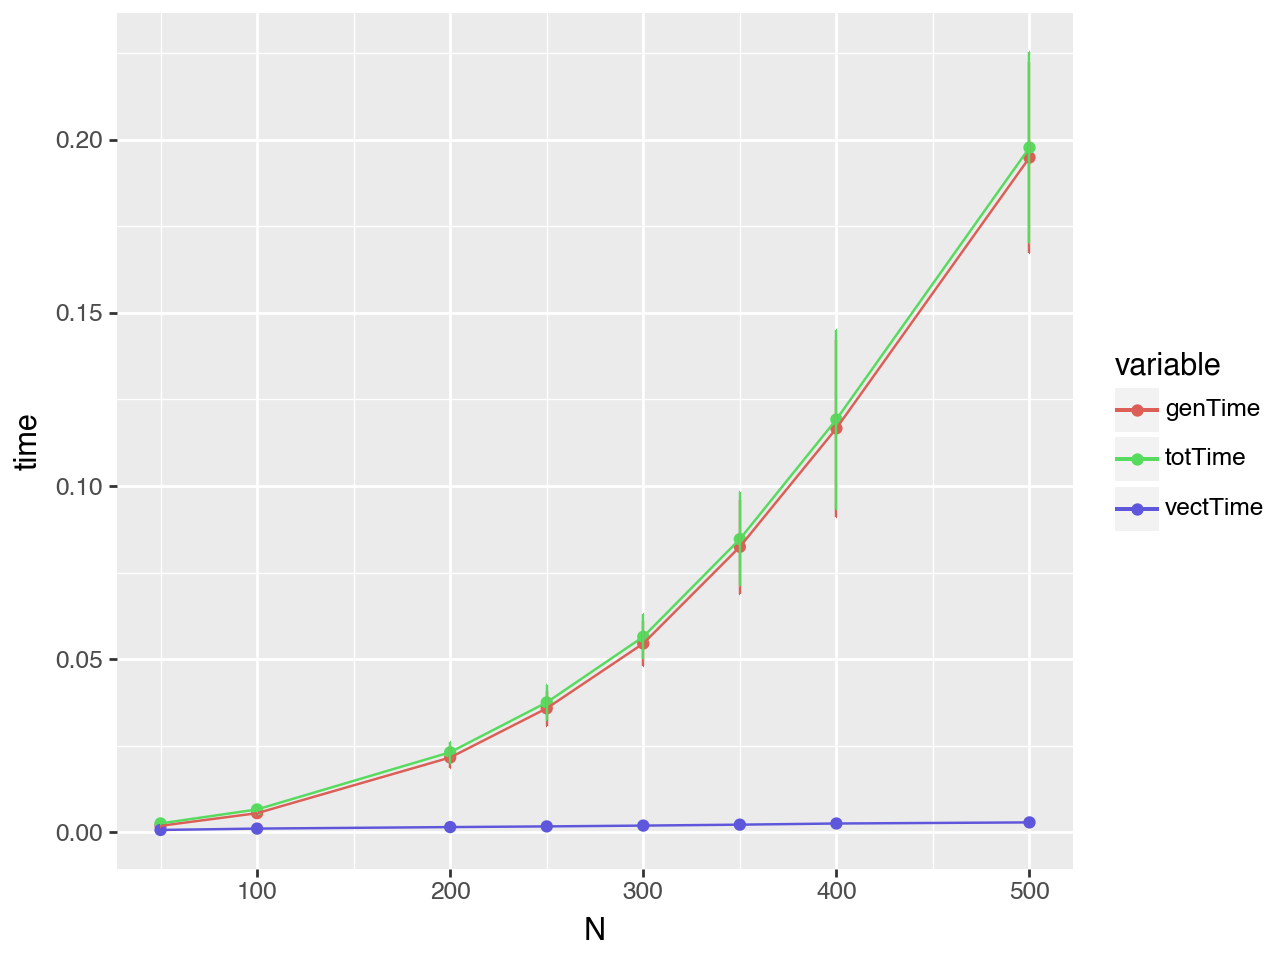

In [192]:
long = pd.melt(times, id_vars="N").groupby(["N", "variable"]).agg(
    mean=("value","mean"), sd=("value", "std"), count=("value", "count")
    ).reset_index()
ggplot(long) + aes(x="N", y="mean", ymin="mean-sd", ymax="mean+sd", color="variable") + \
    geom_point() + geom_line() + geom_errorbar() + \
    labs(x="N", y="time")

As you can see, general picture is the same as in R: generation is long, time increases with N, vectorization is fast

## Time Comparison

Let me compare with R's timings

In [193]:
Rtimes = pd.read_csv("../R/times.csv")
Rlong = pd.melt(Rtimes, id_vars = "N").groupby(["N", "variable"]).agg(
    Rmean=("value","mean"), Rsd=("value", "std"), Rcount=("value", "count")
    ).reset_index()

In [ ]:
joined = long.set_index(["N", "variable"]).join( Rlong.set_index(["N", "variable"])).\
    query("N<500")
joined["rat"] = joined["mean"]/joined["Rmean"]
joined

mean        sd  count     Rmean       Rsd  Rcount        rat
N   variable                                                                  
50  genTime   0.001888  0.000206    100  0.005604  0.001212    50.0   0.336846
    totTime   0.002577  0.000240    100  0.005752  0.001273    50.0   0.448029
    vectTime  0.000688  0.000093    100  0.000058  0.000021    50.0  11.797185
100 genTime   0.005531  0.000818    100  0.046745  0.016635    50.0   0.118320
    totTime   0.006614  0.000843    100  0.046916  0.016655    50.0   0.140970
    vectTime  0.001081  0.000130    100  0.000084  0.000028    50.0  12.830554
200 genTime   0.021612  0.002943    100  0.363639  0.127238    50.0   0.059432
    totTime   0.023131  0.002976    100  0.364093  0.127155    50.0   0.063531
    vectTime  0.001518  0.000111    100  0.000378  0.002023    50.0   4.011940
250 genTime   0.035808  0.005044    100  0.630552  0.045202    50.0   0.056788
    totTime   0.037525  0.005043    100  0.630723  0.045217    50.0   0.059495
    vectTime  0.001716  0.000105    100  0.000099  0.000012    50.0  17.396126
300 genTime   0.054533  0.006541    100  1.162552  0.075474    50.0   0.046908
    totTime   0.056482  0.006547    100  1.162727  0.075474    50.0   0.048577
    vectTime  0.001947  0.000115    100  0.000104  0.000006    50.0  18.649094
350 genTime   0.082457  0.013597    100  1.901651  0.123981    50.0   0.043361
    totTime   0.084675  0.013625    100  1.901831  0.123982    50.0   0.044523
    vectTime  0.002217  0.000127    100  0.000109  0.000004    50.0  20.266945
400 genTime   0.116682  0.025557    100  3.070104  0.188745    50.0   0.038006
    totTime   0.119234  0.025852    100  3.070294  0.188747    50.0   0.038835
    vectTime  0.002550  0.000597    100  0.000119  0.000008    50.0  21.390572

As you can see, generation in Python is much faster, vectorization is slower

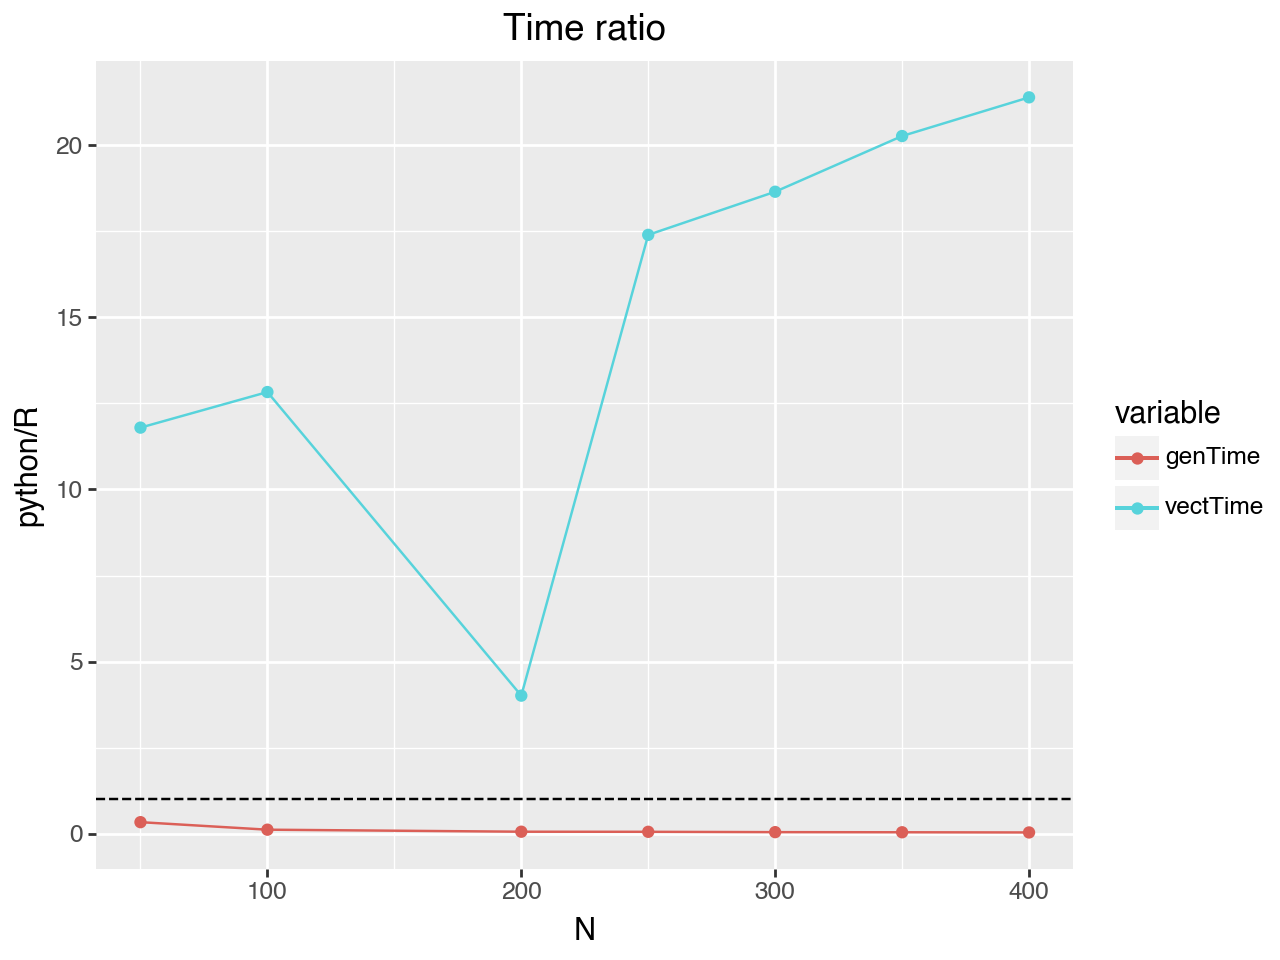

In [195]:
ggplot(
    joined.reset_index().query("variable != 'totTime'")
) + aes(x="N", y="rat", color = "variable") + \
    geom_point() + geom_line() + geom_hline(yintercept=1, linetype = "dashed", size=0.5) + \
    labs(x="N", y="python/R", title="Time ratio")